In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cufflinks as cf
import plotly.offline as py

import seaborn as sns
from datetime import datetime

In [98]:
import datetime

In [99]:
import time

In [82]:
py.init_notebook_mode()

AttributeError: module 'plotly.plotly' has no attribute 'init_notebook_mode'

In [2]:
cdmx_pol = pd.read_csv('contaminantes_2018.CSV')
cdmx_pol.head()

,date,id_station,id_parameter,value,unit
0,01/01/2018 01:00,ACO,CO,0.4,15
1,01/01/2018 01:00,ACO,NO,3.0,1
2,01/01/2018 01:00,ACO,NO2,23.0,1
3,01/01/2018 01:00,ACO,NOX,25.0,1
4,01/01/2018 01:00,ACO,O3,8.0,1


In [3]:
arranged_table = pd.pivot_table(cdmx_pol, index = ['date', 'id_station'], values=['value', 'unit'], columns = ['id_parameter'])

In [4]:
arranged_table.isna().sum()

       id_parameter
unit   CO               35040
       NO               43800
       NO2              43800
       NOX              43800
       O3                   0
       PM10             87600
       PM2.5           113880
       PMCO            175200
       SO2              26280
value  CO               84467
       NO              114998
       NO2             114998
       NOX             114998
       O3               63223
       PM10            155584
       PM2.5           184345
       PMCO            217584
       SO2              77456
dtype: int64

<h3> There's a lof of NaN values, so we're going to substitute them by the mean of the previous value and the next value that is not NaN:</h3>

In [5]:
col1 = list(arranged_table.columns.levels[0])
col2 = list(arranged_table.columns.levels[1])
for col in col1:
    for val in col2:
        l = [str(i) for i in arranged_table[col][val]]
        
        for x in range(len(l)):
                if x<(len(l)-1) and l[x] == 'nan':
                    y = x-1
                    z = x+1
                    if l[x+1]!='nan':
                        l[x] = str((float(l[y])+float(l[z]))/2)
                    else:
                        while z<(len(l)-1) and l[z]=='nan':
                            z +=1
                        l[x] = str((float(l[y])+float(l[z]))/2)
                else:
                    pass
        arranged_table[col][val] = [float(i) for i in l]

<h3>There's a cluster of 'NaN' values in the last rows of the dataset, that belong to December 31, 00:00. We can assume no values were recorded at that time so we're going to drop them:</h3>

In [6]:
arranged_table = arranged_table[:297806]

In [7]:
arranged_table.isna().sum()

       id_parameter
unit   CO              0
       NO              0
       NO2             0
       NOX             0
       O3              0
       PM10            0
       PM2.5           0
       PMCO            0
       SO2             0
value  CO              0
       NO              0
       NO2             0
       NOX             0
       O3              0
       PM10            0
       PM2.5           0
       PMCO            0
       SO2             0
dtype: int64

In [8]:
arranged_table.head()

unit                                           \
id_parameter                   CO   NO  NO2  NOX   O3 PM10 PM2.5 PMCO  SO2   
date             id_station                                                  
01/01/2018 01:00 ACO         15.0  1.0  1.0  1.0  1.0  2.0   2.0  2.0  1.0   
                 AJM         15.0  1.0  1.0  1.0  1.0  2.0   2.0  2.0  1.0   
                 AJU         15.0  1.0  1.0  1.0  1.0  2.0   2.0  2.0  1.0   
                 ATI         15.0  1.0  1.0  1.0  1.0  2.0   2.0  2.0  1.0   
                 BJU         15.0  1.0  1.0  1.0  1.0  2.0   2.0  2.0  1.0   

                            value                                        \
id_parameter                   CO   NO     NO2   NOX    O3   PM10 PM2.5   
date             id_station                                               
01/01/2018 01:00 ACO          0.4  3.0  23.000  25.0   8.0  125.0  70.0   
                 AJM          0.8  2.0  25.000  26.0  31.0   92.0  65.0   
                 AJU          0.8  2.0  30.500  32.0  17.0   85.0  49.0   
                 ATI          0.8  2.0  33.250  35.0  17.0   81.5  52.5   
                 BJU          0.6  2.0  34.625  36.5  22.0   78.0  56.0   

                                          
id_parameter                  PMCO   SO2  
date             id_station               
01/01/2018 01:00 ACO         43.00   2.0  
                 AJM         27.00   6.0  
                 AJU         24.50  10.0  
                 ATI         23.25  14.0  
                 BJU         22.00   9.0

<h3> No NaN values! </h3>

In [9]:
arranged_table.drop('unit', axis=1, inplace=True)

I'm dropping the unit column as there's no important values, only the metric unit for the values:
<li>1) Parts per billion: NO, NO2, NOX,O3, SO2</li>
<li>2) µg/m³: PM10, PM2.5, PMCO</li>
<li>3) Parts per million: CO</li>
<br>
I will add those to the 'y' axis later to identify the parameter of the graph

<h3> Let's now rearrange the table for plotting: </h3>

In [11]:
weekdays_polution = arranged_table.reset_index()
weekdays_polution = pd.pivot_table(weekdays_polution, index = ['date'], values=['value'], aggfunc='mean')
weekdays_polution = weekdays_polution.reset_index()
weekdays_polution = weekdays_polution.droplevel(0,1)
weekdays_polution.columns = [['date', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'PMCO', 'SO2']]
weekdays_polution['date'] = weekdays_polution['date'].apply(lambda x: x+':00')
weekdays_polution.columns = ['_'.join(col) for col in weekdays_polution.columns]
weekdays_polution['date'] = weekdays_polution['date'].apply(lambda x: x.replace(' 24', ' 00'))
weekdays_polution['date'] = weekdays_polution['date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))
weekdays_polution['day_of_week'] = weekdays_polution['date'].dt.dayofweek
weekdays_polution = weekdays_polution.get(weekdays_polution['day_of_week']<6)

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:3812: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [59]:
weekdays_polution['date'] = weekdays_polution['date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))

Let's split the data into particles to plot:

In [123]:
weekdays_polution['date_s'] = weekdays_polution['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
weekdays_polution[['date_s', 'time']]= weekdays_polution['date_s'].str.split(" ", expand=True)

In [124]:
NO_weekday_time = weekdays_polution[['date', 'NO', 'day_of_week', 'date_s', 'time']]
NO2_weekday_time = weekdays_polution[['date', 'NO2', 'day_of_week', 'date_s', 'time']]
NOX_weekday_time = weekdays_polution[['date', 'NOX', 'day_of_week', 'date_s', 'time']]
O3_weekday_time = weekdays_polution[['date','O3', 'day_of_week', 'date_s', 'time']]
SO2_weekday_time = weekdays_polution[['date', 'SO2', 'day_of_week', 'date_s', 'time']]

PM10_time = weekdays_polution[['date', 'PM10', 'day_of_week', 'date_s', 'time']]
PM25_weekday_time = weekdays_polution[['date', 'PM2.5', 'day_of_week', 'date_s', 'time']]
PMCO_weekday_time = weekdays_polution[['date','PMCO', 'day_of_week', 'date_s', 'time']]

CO_weekday_time = weekdays_polution[['date','CO', 'day_of_week', 'date_s', 'time']]

In [151]:
NO_weekday_time = weekdays_polution[['NO', 'date_s']].groupby('date_s').mean().reset_index()
NO2_weekday_time = weekdays_polution[['NO2', 'date_s']].groupby('date_s').mean().reset_index()
NOX_weekday_time = weekdays_polution[['NOX', 'date_s']].groupby('date_s').mean().reset_index()
O3_weekday_time = weekdays_polution[['O3', 'date_s']].groupby('date_s').mean().reset_index()
SO2_weekday_time = weekdays_polution[['SO2','date_s']].groupby('date_s').mean().reset_index()

PM10_time = weekdays_polution[['PM10','date_s']].groupby('date_s').mean().reset_index()
PM25_weekday_time = weekdays_polution[['PM2.5','date_s']].groupby('date_s').mean().reset_index()
PMCO_weekday_time = weekdays_polution[['PMCO', 'date_s']].groupby('date_s').mean().reset_index()

CO_weekday_time = weekdays_polution[['CO', 'date_s']].groupby('date_s').mean().reset_index()

I want to compare the maximums established by the WHO and see how many 'violations' of those rules we're exposing ourselves to during which amounts of time:

<h2> DAILY MEAN EVALUATION </h2>
<br>
PM10, PM2.5 and SO2 have maximum levels on a 24 hour basis, let's sort them by date and see the trespassing values:

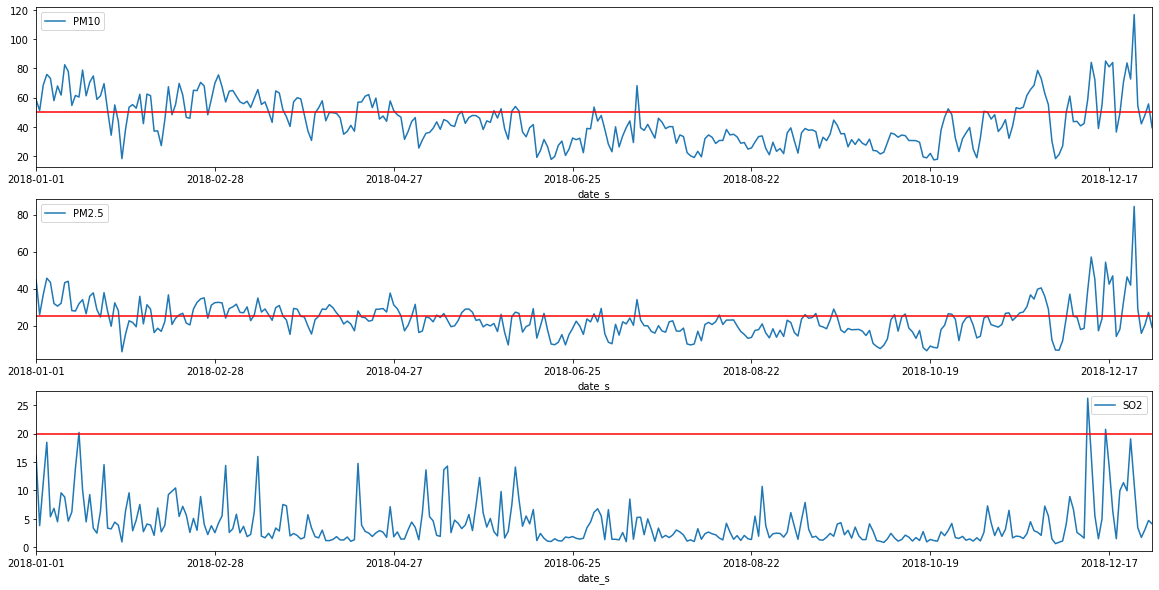

In [165]:
PM10_24h_mean = weekdays_polution[['PM10','date_s']].groupby('date_s').mean().reset_index()
PM25_24h_mean = weekdays_polution[['PM2.5','date_s']].groupby('date_s').mean().reset_index()
SO2_24h_mean = weekdays_polution[['SO2', 'date_s']].groupby('date_s').mean().reset_index()

fig, axs = plt.subplots(3, figsize = (20,10))
PM10_24h_mean.plot(x='date_s', y='PM10',  ax=axs[0])
axs[0].axhline(y= 50, color='r')
PM25_24h_mean.plot(x='date_s', y='PM2.5', ax=axs[1])
axs[1].axhline(y= 25, color='r')
SO2_24h_mean.plot(x='date_s', y='SO2', ax=axs[2])
axs[2].axhline(y= 20, color='r')

We can see a lot of days in the year where the maximum threshold is surpassed. Let's look at the distributions to see the number of violations in the cases of PM10 and PM2.5:

In [175]:
PM_10_max_std = (50 - PM10_24h_mean.mean())/PM10_24h_mean.std()
PM_25_max_std = (25 - PM25_24h_mean.mean())/PM25_24h_mean.std()

In [195]:
PM10_24h_mean.mean()[0]

44.07561884088195

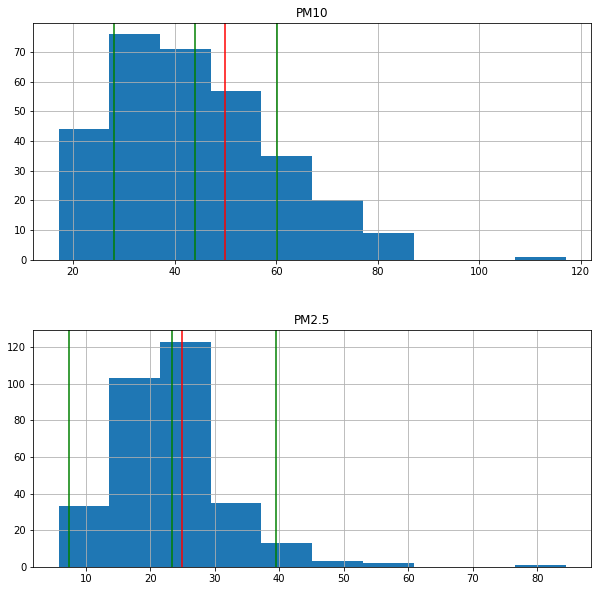

In [198]:
fig, axs = plt.subplots(2,1, figsize = (10,10))
PM10_24h_mean.hist(ax=axs[0])
axs[0].axvline(50, color='r')
axs[0].axvline(PM10_24h_mean.mean()[0], color='g')
axs[0].axvline(PM10_24h_mean.mean()[0]+PM10_24h_mean.std()[0], color='g')
axs[0].axvline(PM10_24h_mean.mean()[0]-PM10_24h_mean.std()[0], color='g')
PM25_24h_mean.hist(ax=axs[1])
axs[1].axvline(25, color='r')
axs[1].axvline(PM25_24h_mean.mean()[0], color='g')
axs[1].axvline(PM25_24h_mean.mean()[0]+PM10_24h_mean.std()[0], color='g')
axs[1].axvline(PM25_24h_mean.mean()[0]-PM10_24h_mean.std()[0], color='g')

In [202]:
PM10_24h_mean.head()

,date_s,PM10,Exc
0,2018-01-01,58.489388,1
1,2018-01-02,51.153033,1
2,2018-01-03,68.540901,1
3,2018-01-04,75.927390,1
4,2018-01-05,73.299058,1


Let's see it more graphically:

In [210]:
PM10_24h_mean['Exc'] = PM10_24h_mean['PM10'].apply(lambda x: 'Not dangerous day' if x<50  else ('Very Dangerous levels' if x>99 else 'Dangerous levels'))
PM25_24h_mean['Exc'] = PM25_24h_mean['PM2.5'].apply(lambda x: 'Not dangerous day' if x<25 else ('Very Dangerous levels' if x>50 else 'Dangerous levels'))

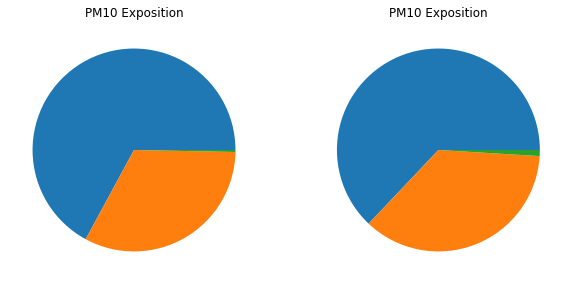

In [221]:
fig, axs = plt.subplots(1,2, figsize = (10,10))
axs[0].pie(PM10_24h_mean['Exc'].value_counts())
axs[0].set_title('PM10 Exposition')
axs[1].pie(PM25_24h_mean['Exc'].value_counts())
axs[1].set_title('PM10 Exposition')
plt.show()

<h3>More than 100 days a year (1/3) we are dramatically exposed to carcirogen particles in a 24h-basis</h3>

<table style="width:100%">
  <tr>
    <th>PM10</th>
    <th>PM2.5</th> 
    <th>Basis for the level</th>
  </tr>
  <tr>
    <td>150</td>
    <td>75</td> 
    <td>Based on published risk coefficients from multi-centre
studies and meta-analyses (about 5% increase of shortterm mortality over the AQG value).</td>
  </tr>
  <tr>
    <td>100</td>
    <td>50</td> 
    <td>about 2.5% increase of shortterm mortality</td>
  </tr>
    <tr>
        <td>75</td>
        <td>37.5</td> 
        <td>about 1.2% increase in short-term mortality</td>
      </tr>
</table>

<h3>Let's take a look at NO2, NO and NOX particles:</h3>

I'm going to plot all values to see the distribution over time of the particles concentration (The peaks do not represent the magnitude of the particle I'm interested in patterns:

<h3>Let's take a look at Ozone concentrations.</h3>
<br>
Maximum levels are stated at 100mg concentrations means on 8h. exposures.
We're going to bin time frames and see how many over-exposures we get by separating the day in three:

In [226]:
O3_weekday_time = weekdays_polution[['O3', 'date_s', 'time']]
O3_weekday_time['time'] = O3_weekday_time['time'].apply(lambda x: x.replace(':00:00', ''))

In [223]:

O3_weekday_time['time'] = O3_weekday_time['time'].apply(lambda x: 'Seg1' if x>7 else('Seg2' if x>16))

ValueError: Input array must be 1 dimensional

We see significant relations between CO, NO, NO2 and NOX

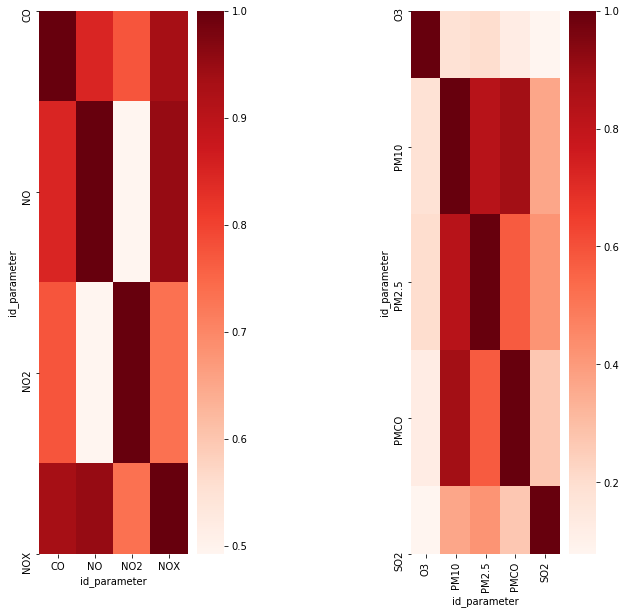

In [79]:
f, axes = plt.subplots(1, 2, figsize=(10,10))
sns.heatmap(pol_part_corr_1, cmap="Reds", ax=axes[0])
sns.heatmap(pol_part_corr_2, cmap="Reds", ax=axes[1]) 
plt.subplots_adjust(wspace = 1)
plt.xticks(rotation=90)
plt.yticks(rotation=90)
plt.show()

#Note: This has been extremly difficult for me(subplotting with plotly) for, apparently, some version issues, and I can proudly say I answered the problem in the only question about it in stack overflow, later stated as correct by a plotly developer :)) https://stackoverflow.com/questions/52598821/subplots-in-plotly-cufflinks-how-to-put-two-subplots-in-the-same-plot/57235349?noredirect=1#comment100974054_57235349

In [35]:
#Also works eventually:
#from plotly import tools
#import plotly.plotly as py
#import plotly.graph_objs as go

#trace1 = pol_part_corr_1.corr().iplot(kind='heatmap',colorscale="Reds", title="CO, NO2, NO, NOX")
#trace2 = pol_part_corr_2.corr().iplot(kind='heatmap',colorscale="Reds", title="O3, SO2, PM2.5, PM10, PMCO")

#fig = tools.make_subplots(rows=2, cols=1)

#fig.add_traces(trace1)
#fig.add_traces(trace2)



#fig['layout'].update(height=600, width=600, title='PARTICLES CORRELATION')
#py.plot(fig, filename='subplots-shared-xaxes')

In [39]:
pol_part_corr_1 = pol_part_corr.loc['CO':'NOX','CO':'NOX']
pol_part_corr_2 = pol_part_corr.loc['O3':,'O3':]

We can see there's three groups of highly-correlated particles: CO, NOX, NO, NO2 and PM10, PM2.5, PMCO and, somehow, SO2 and O3, seem to interact more with those. Let's split them:

In [32]:
#pol_part_corr.iplot(kind='heatmap',colorscale="Reds", title="Particles Correlation Matrix")
#The code is right but somehow it does not work eventually


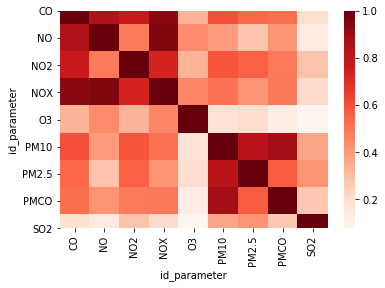

In [31]:
sns.heatmap(pol_part_corr, cmap="Reds")

In [27]:
pol_part_corr = pol_by_time.corr()
f = lambda x: x*-1 if x<0 else x

for col in list(pol_part_corr.columns):
    pol_part_corr[col] = pol_part_corr[col].apply(f)

As we only care for the magnitude of the relation and not the type of the relation between the values, we're going to set all values to positive:

In [15]:
pol_by_time = arranged_table.drop('id_station', axis=1)
pol_by_time = arranged_table.groupby(['time', 'date']).mean()
pol_by_time.head()

id_parameter            CO         NO        NO2        NOX         O3  \
time  date                                                               
01:00 01/01/2018  0.727941   3.522059  30.490809  34.022059  19.415441   
      01/02/2018  0.716728  51.915441  28.477941  80.408088   3.985294   
      01/03/2018  0.197059   0.294118  10.323529  11.558824  42.264706   
      01/04/2018  0.321324   2.602941  24.716912  27.356618  19.544118   
      01/05/2018  0.129779   1.029412  15.102941  16.000000  26.889706   

id_parameter            PM10      PM2.5       PMCO       SO2  
time  date                                                    
01:00 01/01/2018  104.009191  68.490809  28.763557  7.477941  
      01/02/2018   45.318015  16.176471  25.072610  2.536765  
      01/03/2018   67.005515  33.548713  32.500460  1.029412  
      01/04/2018   36.018382  18.181066  18.380515  1.617647  
      01/05/2018   21.555147  14.277574   8.181526  0.845588

Let's look at the mean of the whole city, by particle over time:

In [14]:
arranged_table.head()

id_parameter,date,id_station,CO,NO,NO2,NOX,O3,PM10,PM2.5,PMCO,SO2,time
0,01/01/2018,ACO,0.4,3.0,23.000,25.0,8.0,125.0,70.0,43.00,2.0,01:00
1,01/01/2018,AJM,0.8,2.0,25.000,26.0,31.0,92.0,65.0,27.00,6.0,01:00
2,01/01/2018,AJU,0.8,2.0,30.500,32.0,17.0,85.0,49.0,24.50,10.0,01:00
3,01/01/2018,ATI,0.8,2.0,33.250,35.0,17.0,81.5,52.5,23.25,14.0,01:00
4,01/01/2018,BJU,0.6,2.0,34.625,36.5,22.0,78.0,56.0,22.00,9.0,01:00


In [13]:
arranged_table[['date', 'time']] = arranged_table.date.str.split(" ",expand=True)

In [12]:
particles = ['CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5', 'PMCO', 'SO2']
stations = list(arranged_table['id_station'].unique())

In [11]:
arranged_table.reset_index(inplace=True)

In [200]:
arranged_table = arranged_table['value']